<a href="https://www.kaggle.com/code/syedahafsasalman/know-your-food-nutrition-analysis-using-ml-ai?scriptVersionId=283203747" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food-nutrition-dataset-150-everyday-foods/Food_Nutrition_Dataset.csv


# Food Nutrition Analysis & Modeling

**Author:** Syeda Hafsa Salman  
**Dataset:** `Food_Nutrition_Dataset.csv` (source: USDA FoodData Central via curated dataset)

**What you'll learn in this notebook**:
- Clean and explore nutrition data
- Visualize nutrient distributions and category-wise comparisons
- Use clustering to find groups of similar foods
- Build simple regression models to predict calories from macro + micro nutrients
- Build a binary classifier for `High Calorie` foods

Let's get started! 🚀


# **Setup & Imports**

In [2]:
# Cell 2: imports and plotting configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score

# plotting styles
sns.set(style='whitegrid')
%matplotlib inline

# display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


# Load Data

In [3]:
# Cell 3: load dataset
path = '/kaggle/input/food-nutrition-dataset-150-everyday-foods/Food_Nutrition_Dataset.csv'
df = pd.read_csv(path)
print('Shape:', df.shape)
df.head()


Shape: (205, 8)


,food_name,category,calories,protein,carbs,fat,iron,vitamin_c
0,"Apple, candied",Apples,134.0,1.34,29.61,2.15,0.12,3.6
1,"Apple, raw",Apples,61.0,0.17,14.80,0.15,0.03,4.6
2,"Apple, dried",Dried fruits,243.0,0.93,65.89,0.32,1.40,3.9
3,"Crisp, apple",Cakes and pies,215.0,2.81,30.18,9.59,1.00,0.6
4,"Apple, baked",Apples,113.0,0.32,22.70,3.08,0.19,3.9


# Basic Info

In [4]:
# Cell 4: basic info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   food_name  205 non-null    object 
 1   category   205 non-null    object 
 2   calories   205 non-null    float64
 3   protein    205 non-null    float64
 4   carbs      205 non-null    float64
 5   fat        205 non-null    float64
 6   iron       203 non-null    float64
 7   vitamin_c  202 non-null    float64
dtypes: float64(6), object(2)
memory usage: 12.9+ KB


# Cleaning explanation

### Take note of dtypes and missing values. We'll clean and ensure numeric columns are floats and impute minor missing values.


# Cleaning & numeric conversion

In [5]:
# Cell 6: convert numeric columns (if strings) and check / impute missing
num_cols = ['calories','protein','carbs','fat','iron','vitamin_c']

# Ensure numeric dtype
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Report missing before imputation
print("Missing before imputation:")
print(df[num_cols].isnull().sum())

# Impute small missing values with median (robust)
for c in num_cols:
    if df[c].isnull().sum() > 0:
        df[c] = df[c].fillna(df[c].median())


# Clean text columns
if 'category' in df.columns:
    df['category'] = df['category'].astype(str).str.strip().str.title()
if 'food_name' in df.columns:
    df['food_name'] = df['food_name'].astype(str).str.strip()

# Final check
print("\nMissing after imputation:")
print(df[num_cols].isnull().sum())


Missing before imputation:
calories     0
protein      0
carbs        0
fat          0
iron         2
vitamin_c    3
dtype: int64

Missing after imputation:
calories     0
protein      0
carbs        0
fat          0
iron         0
vitamin_c    0
dtype: int64


# Summary statistics

In [6]:
# Cell 7: descriptive statistics
round(df[num_cols].describe().T,2)


,count,mean,std,min,25%,50%,75%,max
calories,205.0,243.79,283.58,16.00,62.00,166.00,296.00,1460.00
protein,205.0,2.85,3.36,0.00,0.64,1.71,3.20,17.80
carbs,205.0,25.57,20.12,1.79,11.20,17.22,37.55,85.13
fat,205.0,6.02,9.69,0.00,0.20,1.18,9.39,74.02
iron,205.0,0.85,1.10,0.00,0.21,0.41,1.06,9.09
vitamin_c,205.0,13.60,18.38,0.00,1.70,7.45,16.70,136.00


### Observe spread, mean, min, max for calories and macros. This gives a feel for the data diversity (fruits vs fried snacks etc.).


# Distribution plots

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

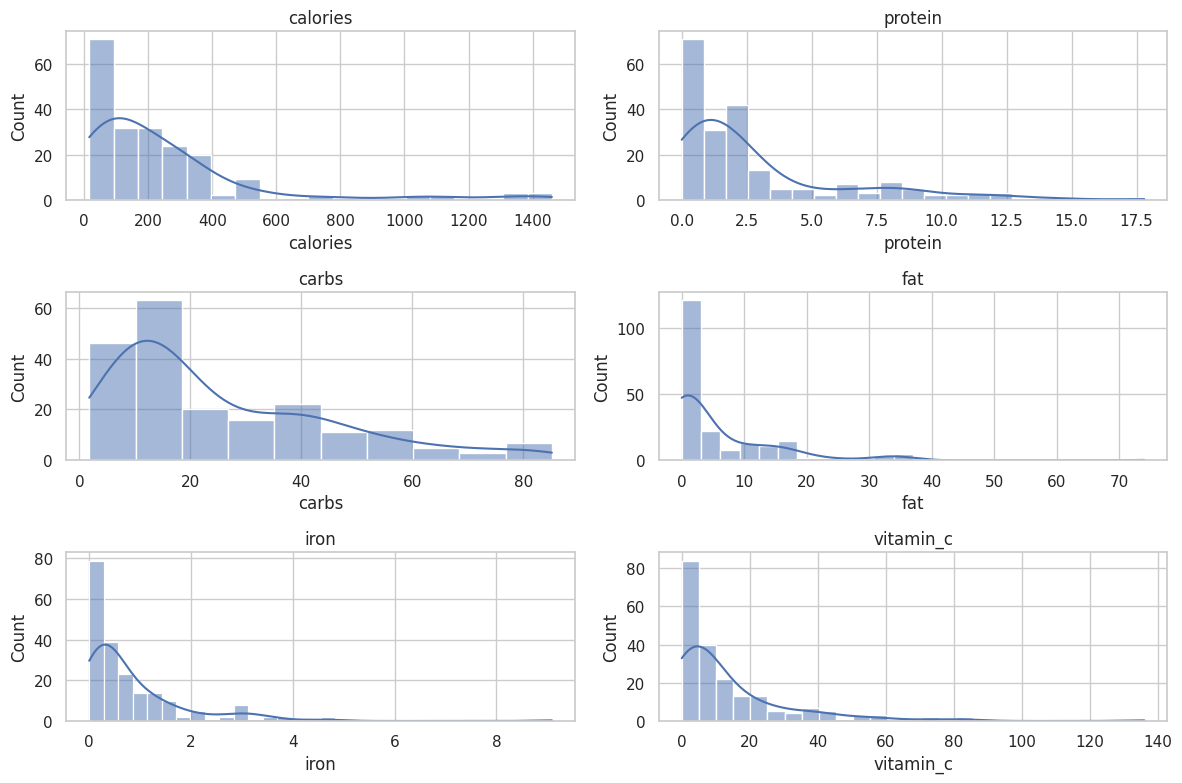

In [7]:
# Cell 9: histograms for numeric features
plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3,2,i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()


# Top / bottom foods by nutrients

In [8]:
# Cell 10: top 10 highest calorie foods and highest protein
print('Top 10 calories:')
display(df[['food_name','category','calories']].sort_values('calories', ascending=False).head(10))

print('\nTop 10 protein (per 100g):')
display(df[['food_name','category','protein']].sort_values('protein', ascending=False).head(10))


Top 10 calories:


,food_name,category,calories
192,"Garlic bread, frozen",Baked Products,1460.0
195,"PIZZA HUT, breadstick, parmesan garlic",Fast Foods,1430.0
202,"Fast foods, breadstick, soft, prepared with ga...",Fast Foods,1430.0
66,"Mango, dried, sweetened",Fruits And Fruit Juices,1340.0
110,"Blueberries, dried, sweetened",Fruits And Fruit Juices,1330.0
113,"Muffins, blueberry, toaster-type",Baked Products,1310.0
123,"Bread, potato",Baked Products,1120.0
84,"Pears, dried, sulfured, uncooked",Fruits And Fruit Juices,1100.0
7,"Croissants, apple",Baked Products,1060.0
90,"Toppings, strawberry",Sweets,1060.0



Top 10 protein (per 100g):


,food_name,category,protein
203,"HORMEL ALWAYS TENDER, Pork Loin Filets, Lemon ...",Pork Products,17.80
34,Orange chicken,Stir-Fry And Soy-Based Sauce Mixtures,14.46
156,Sun-dried tomatoes,Tomatoes,14.11
123,"Bread, potato",Baked Products,12.50
195,"PIZZA HUT, breadstick, parmesan garlic",Fast Foods,12.20
202,"Fast foods, breadstick, soft, prepared with ga...",Fast Foods,12.20
165,Pork with chili and tomatoes,Meat Mixed Dishes,11.64
199,"Shrimp in garlic sauce, Puerto Rican style",Seafood Mixed Dishes,11.56
201,"Garlic bread, with melted cheese, from fast fo...",Yeast Breads,11.41
191,"Roll, garlic",Rolls And Buns,10.84


# Category comparisons

In [9]:
# Cell 11: groupby category mean nutrient values
cat_stats = df.groupby('category')[num_cols].mean().sort_values('calories', ascending=False)
cat_stats.head(12)


,calories,protein,carbs,fat,iron,vitamin_c
category,,,,,,
Baked Products,1184.200000,6.932000,42.820000,9.586000,1.442000,0.680000
Fast Foods,937.500000,7.920000,36.575000,8.720000,2.402500,2.562500
Sweets,530.500000,0.933333,46.250000,1.833333,0.315000,4.966667
Potato Chips,529.500000,6.415000,55.022500,33.080000,1.500000,28.150000
Snacks,519.000000,2.300000,58.400000,33.600000,1.250000,6.300000
"Tortilla, Corn, Other Chips",514.000000,5.310000,60.820000,27.395000,2.915000,0.900000
Pork Products,492.000000,17.800000,1.790000,4.160000,0.600000,1.700000
Restaurant Foods,385.000000,5.290000,41.000000,22.200000,0.740000,7.450000
Fruits And Fruit Juices,336.652174,0.918261,23.737826,0.394348,0.459565,28.291304


# Barplot: mean calories per category

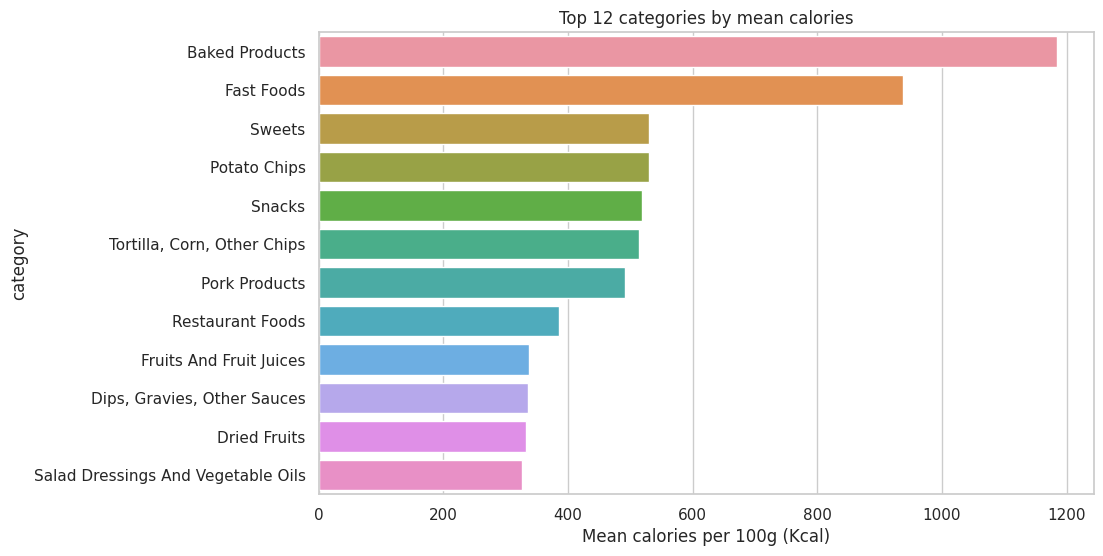

In [10]:
# Cell 12: barplot: mean calories per category (top 12)
plt.figure(figsize=(10,6))
sns.barplot(y=cat_stats.head(12).index, x=cat_stats.head(12)['calories'])
plt.xlabel('Mean calories per 100g (Kcal)')
plt.title('Top 12 categories by mean calories')
plt.show()


# Correlation matrix & heatmap

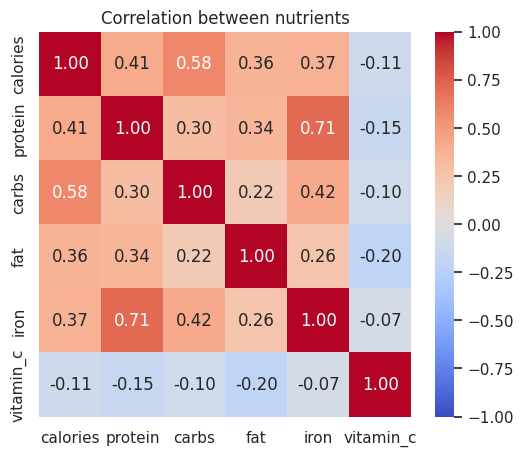

In [11]:
# Cell 13: correlation
corr = df[num_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between nutrients')
plt.show()


### Note which macronutrients correlate with calories (usually fat & carbs), and if any micronutrients co-vary.


# Feature engineering — Atwater estimate

In [12]:
# Cell 15: feature engineering - Atwater factors (kcal/g): protein=4, carbs=4, fat=9
df['est_cal_from_macros'] = df['protein']*4 + df['carbs']*4 + df['fat']*9
df['calorie_diff_pct'] = np.where(df['calories'] != 0,
                                  (df['calories'] - df['est_cal_from_macros']) / df['calories'] * 100,
                                  0.0)
# Show biggest positive and negative percent diffs
display(df[['food_name','category','calories','est_cal_from_macros','calorie_diff_pct']].sort_values('calorie_diff_pct', ascending=False).head(10))
display(df[['food_name','category','calories','est_cal_from_macros','calorie_diff_pct']].sort_values('calorie_diff_pct').head(10))


,food_name,category,calories,est_cal_from_macros,calorie_diff_pct
203,"HORMEL ALWAYS TENDER, Pork Loin Filets, Lemon ...",Pork Products,492.0,115.80,76.463415
71,"Fruit juice smoothie, NAKED JUICE, MIGHTY MANGO",Fruits And Fruit Juices,262.0,61.68,76.458015
26,"Melon, banana (Navajo)",American Indian/Alaska Native Foods,90.0,21.40,76.222222
123,"Bread, potato",Baked Products,1120.0,266.57,76.199107
114,"Pie fillings, blueberry, canned",Sweets,757.0,181.04,76.084544
55,"Beverages, OCEAN SPRAY, Cran Grape",Beverages,224.0,53.64,76.053571
192,"Garlic bread, frozen",Baked Products,1460.0,349.64,76.052055
202,"Fast foods, breadstick, soft, prepared with ga...",Fast Foods,1430.0,342.90,76.020979
195,"PIZZA HUT, breadstick, parmesan garlic",Fast Foods,1430.0,342.90,76.020979
7,"Croissants, apple",Baked Products,1060.0,256.30,75.820755


,food_name,category,calories,est_cal_from_macros,calorie_diff_pct
130,Sweet potato tots,Fried Vegetables,191.0,242.39,-26.905759
145,"Sweet potato fries, frozen",Fried Vegetables,192.0,243.39,-26.765625
147,"Sweet potato fries, school",Fried Vegetables,192.0,243.39,-26.765625
146,"Sweet potato fries, NFS",Fried Vegetables,192.0,243.39,-26.765625
142,"Sweet potato tots, school",Fried Vegetables,192.0,243.39,-26.765625
157,"Tomatoes, red, ripe, canned, packed in tomato ...",Vegetables And Vegetable Products,16.0,19.29,-20.562500
171,"Onions, green, raw",Onions,32.0,38.39,-19.968750
28,"Peppers, banana, raw",Other Vegetables And Combinations,27.0,32.09,-18.851852
27,"Pepper, banana, raw",Vegetables And Vegetable Products,27.0,32.09,-18.851852
156,Sun-dried tomatoes,Tomatoes,258.0,306.21,-18.686047


### The Atwater estimate often closely matches calories for whole foods. Large discrepancies highlight items with water, fiber, or rounding differences.


# PCA visualization

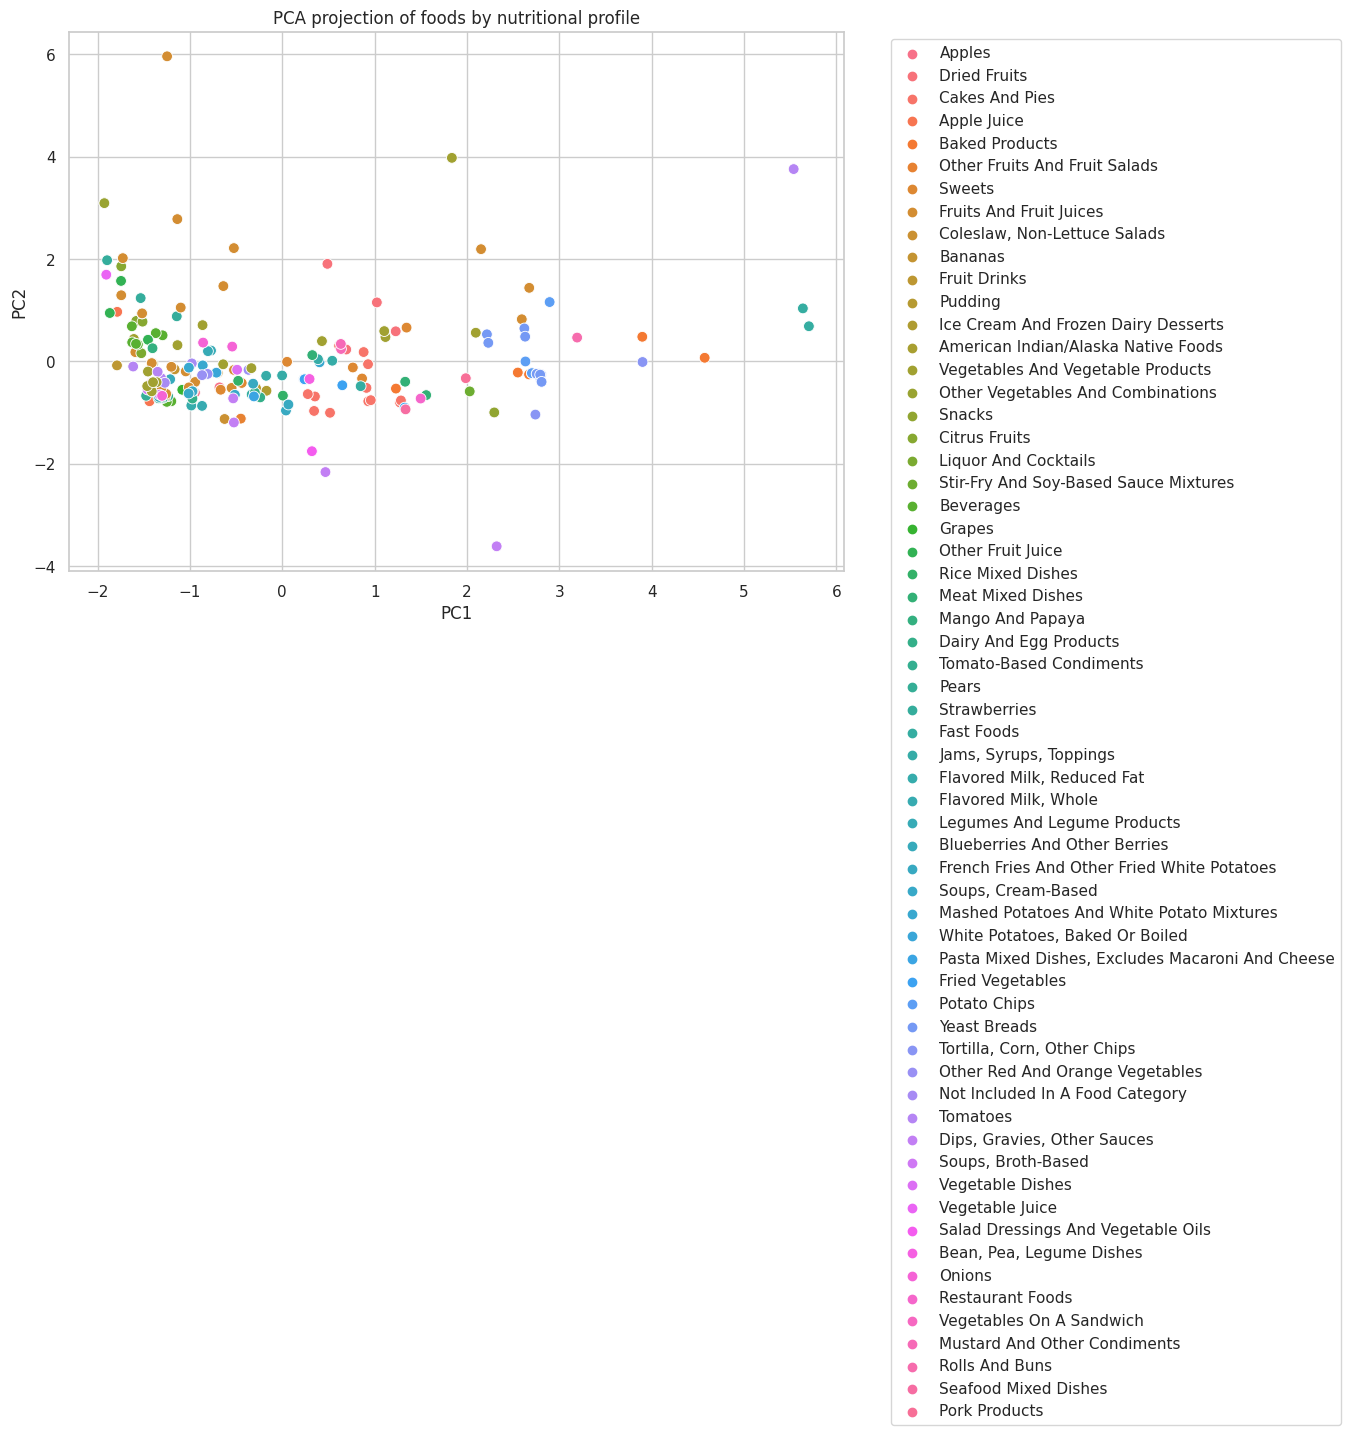

In [13]:
# Cell 17: PCA to project foods into 2D using numeric nutrition features
X = df[num_cols].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(proj, columns=['PC1','PC2'])
pca_df = pd.concat([pca_df, df[['food_name','category']].reset_index(drop=True)], axis=1)

plt.figure(figsize=(10,7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='category', legend='full', s=60)
plt.title('PCA projection of foods by nutritional profile')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# KMeans — elbow

In [14]:
# Cell 18: KMeans elbow (try k from 2 to 6)
inertias = {}
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    inertias[k] = km.fit(scaler.transform(df[num_cols])).inertia_

inertias


{2: 833.6754695290797,
 3: 700.2050182318138,
 4: 595.6012925353252,
 5: 511.7211340124064,
 6: 444.9965745718003}

# KMeans elbow plot

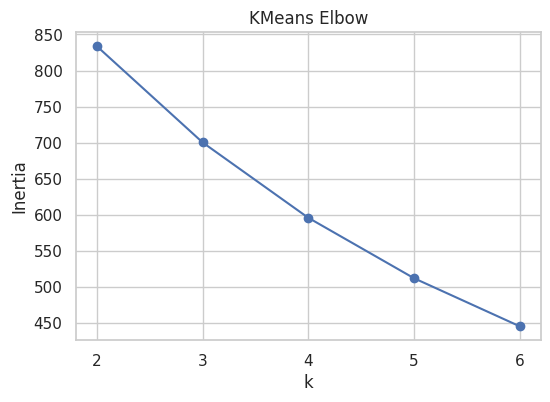

In [15]:
# Cell 19: elbow plot
plt.figure(figsize=(6,4))
plt.plot(list(inertias.keys()), list(inertias.values()), marker='o')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.title('KMeans Elbow')
plt.xticks(list(inertias.keys()))
plt.show()


# Fit KMeans and inspect clusters

In [16]:
# Cell 20: Fit KMeans (choose k based on elbow; example k=3)
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = km.fit_predict(scaler.transform(df[num_cols]))
df['cluster'] = clusters

# cluster centers in original scale (inverse transform)
centers = scaler.inverse_transform(km.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=num_cols)
centers_df.index = [f'cluster_{i}' for i in centers_df.index]
centers_df


,calories,protein,carbs,fat,iron,vitamin_c
cluster_0,494.500000,10.192917,36.846250,12.085833,3.034583,4.302083
cluster_1,106.534884,1.420465,14.346124,1.780543,0.414729,16.666279
cluster_2,468.576923,3.018462,48.222692,13.729615,0.909808,10.297115


# Representative foods per cluster

In [17]:
# Cell 21: show sample foods per cluster
for i in range(k):
    print('\n========== Cluster', i, '===========')
    display(df[df['cluster']==i][['food_name','category','calories','protein','carbs','fat']].sort_values('calories', ascending=False).head(8))



========== Cluster 0 ===========


,food_name,category,calories,protein,carbs,fat
192,"Garlic bread, frozen",Baked Products,1460.0,8.36,41.70,16.60
202,"Fast foods, breadstick, soft, prepared with ga...",Fast Foods,1430.0,12.20,44.50,12.90
195,"PIZZA HUT, breadstick, parmesan garlic",Fast Foods,1430.0,12.20,44.50,12.90
123,"Bread, potato",Baked Products,1120.0,12.50,47.10,3.13
179,Onion flavored rings,"Tortilla, Corn, Other Chips",499.0,7.70,65.10,22.60
203,"HORMEL ALWAYS TENDER, Pork Loin Filets, Lemon ...",Pork Products,492.0,17.80,1.79,4.16
47,"Grape leaves, raw",Vegetables And Vegetable Products,390.0,5.60,17.30,2.12
200,"Garlic bread, with parmesan cheese, from fast ...",Yeast Breads,351.0,8.76,41.06,16.80



========== Cluster 1 ===========


,food_name,category,calories,protein,carbs,fat
38,"Orange peel, raw",Fruits And Fruit Juices,405.0,1.50,25.0,0.20
103,"Strawberries, frozen, sweetened, sliced",Fruits And Fruit Juices,402.0,0.53,25.9,0.13
23,"Bananas, raw",Fruits And Fruit Juices,371.0,1.09,22.8,0.33
111,"Blueberries, frozen, sweetened",Fruits And Fruit Juices,355.0,0.40,22.0,0.13
204,"Abiyuch, raw",Fruits And Fruit Juices,290.0,1.50,17.6,0.10
93,"Guavas, strawberry, raw",Fruits And Fruit Juices,289.0,0.58,17.4,0.60
71,"Fruit juice smoothie, NAKED JUICE, MIGHTY MANGO",Fruits And Fruit Juices,262.0,0.42,15.0,0.00
42,"Oranges, raw, with peel",Fruits And Fruit Juices,262.0,1.30,15.5,0.30



========== Cluster 2 ===========


,food_name,category,calories,protein,carbs,fat
66,"Mango, dried, sweetened",Fruits And Fruit Juices,1340.0,2.45,78.6,1.18
110,"Blueberries, dried, sweetened",Fruits And Fruit Juices,1330.0,2.50,80.0,2.50
113,"Muffins, blueberry, toaster-type",Baked Products,1310.0,4.60,53.3,9.50
84,"Pears, dried, sulfured, uncooked",Fruits And Fruit Juices,1100.0,1.87,69.7,0.63
7,"Croissants, apple",Baked Products,1060.0,7.40,37.1,8.70
90,"Toppings, strawberry",Sweets,1060.0,0.20,66.3,0.10
115,"Pie, blueberry, commercially prepared",Baked Products,971.0,1.80,34.9,10.00
94,"Ice creams, strawberry",Sweets,803.0,3.20,27.6,8.40


### mInterpret cluster centers: which cluster corresponds to high-calorie/high-fat foods, which to low-calorie fruits/veg, etc.


# Supervised learning — Regression baseline

In [18]:
# Cell 23: regression baseline
features = ['protein','carbs','fat','iron','vitamin_c']
X = df[features].copy()
y = df['calories'].copy()

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe_lr = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor(random_state=42))])

# Cross-validated RMSE for both (5-fold)
for name, model in [('LinearRegression', pipe_lr), ('RandomForest', pipe_rf)]:
    scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    print(f"{name}: CV RMSE mean={scores.mean():.2f}, std={scores.std():.2f}")

# Fit RandomForest and evaluate on test set
pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)
print('\nTest RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('Test R2:', r2_score(y_test, y_pred))


LinearRegression: CV RMSE mean=210.33, std=50.46
RandomForest: CV RMSE mean=238.59, std=28.15

Test RMSE: 254.25155925740916
Test R2: 0.4365803612780812


### Interpretation: how well can macros+some micros predict calories? RandomForest often outperforms linear model if relationships are non-linear.


# Calorie classification: High vs Low

In [19]:
# Cell 25: create binary label: High calorie if calories > median
median_cal = df['calories'].median()
df['high_calorie'] = (df['calories'] > median_cal).astype(int)

X = df[features].copy()
y = df['high_calorie'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe_clf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=42))])
pipe_clf.fit(X_train, y_train)
y_pred_clf = pipe_clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred_clf))
print('\nClassification report:\n', classification_report(y_test, y_pred_clf))

# Feature importances
imp = pipe_clf.named_steps['rf'].feature_importances_
feat_importance = pd.Series(imp, index=features).sort_values(ascending=False)
feat_importance


Accuracy: 0.8536585365853658

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        24
           1       0.82      0.82      0.82        17

    accuracy                           0.85        41
   macro avg       0.85      0.85      0.85        41
weighted avg       0.85      0.85      0.85        41



carbs        0.372469
fat          0.225087
protein      0.148396
iron         0.132856
vitamin_c    0.121192
dtype: float64

# Model interpretation plots

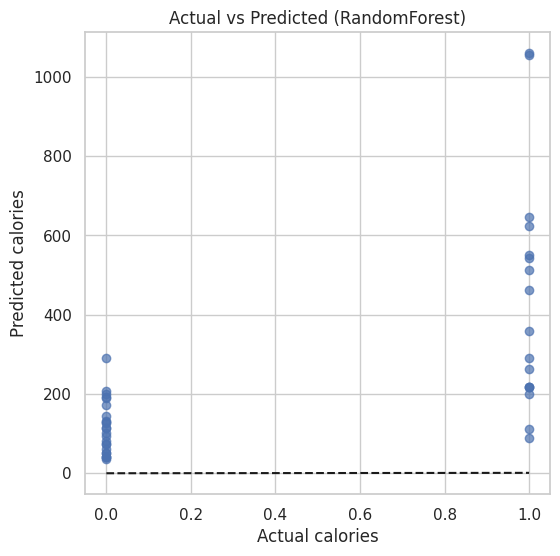

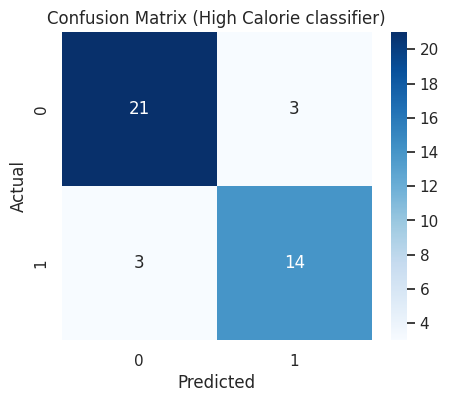

In [20]:
# Cell 26: scatter plot actual vs predicted (regression)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual calories')
plt.ylabel('Predicted calories')
plt.title('Actual vs Predicted (RandomForest)')
plt.show()

# confusion matrix for classifier
cm = confusion_matrix(y_test, y_pred_clf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (High Calorie classifier)')
plt.show()


# Conclusions 

# Conclusions

- The dataset offers a compact collection of everyday foods; EDA shows clear differences across categories.
- Macro nutrients (fat, carbs, protein) explain much of the variation in calories (Atwater approximation).
- Clustering groups foods into sensible clusters (low-calorie produce vs high-calorie snacks/dishes).
- A simple RandomForest regressor predicts calories reasonably well from macro+micro nutrients; classification into high/low calorie performs well too.

